In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import wrf
import pyart
import pandas as pd
import netCDF4 as nc
import tqdm
import cartopy.crs as ccrs


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead


0.3.0


In [2]:
#path = "/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead/highres_d04_2023-10-16_"
path = "/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa/highres_d04_2023-10-16_"
times = ["02:30:00","03:30:00","04:30:00","05:30:00","06:30:00"]
wrf_list = [nc.Dataset(path+t) for t in times]

In [3]:
def wind_speed(wrf_list):
    wspd_wdir10 = wrf.getvar(wrf_list,"wspd_wdir10",timeidx=wrf.ALL_TIMES)
    lats, lons = wrf.latlon_coords(wspd_wdir10)
    return wspd_wdir10, lons, lats

wspd_wdir10, wrf_lons, wrf_lats = wind_speed(wrf_list)
wspd_wdir10 = wspd_wdir10.persist()
theta_e = wrf.getvar(wrf_list,"theta_e",timeidx=wrf.ALL_TIMES).isel(bottom_top=0).persist()

100%|██████████| 5/5 [00:01<00:00,  2.88it/s]


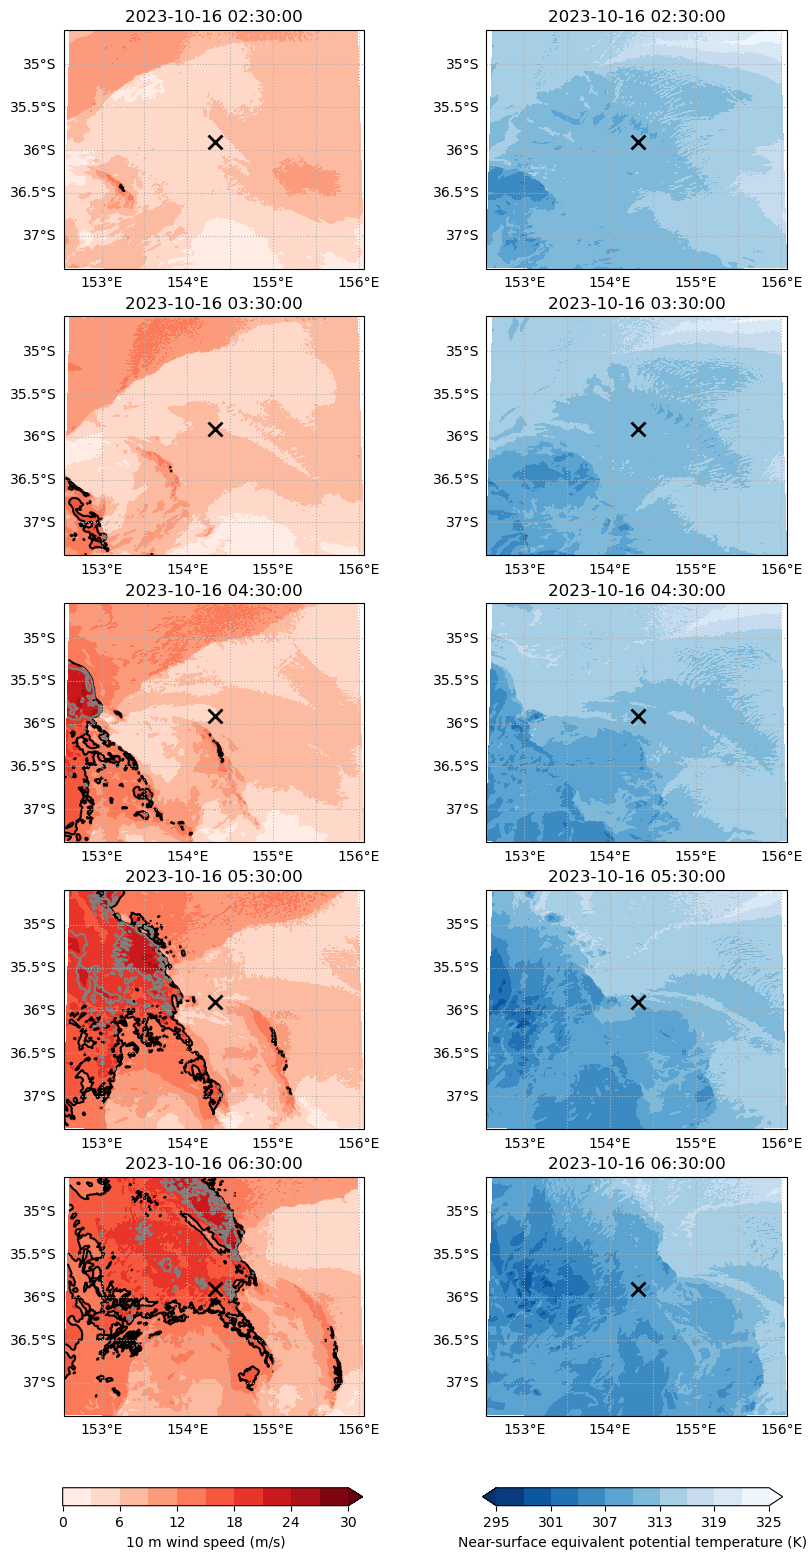

In [4]:
def add_lines(ax):
    g=ax.gridlines(draw_labels=True,linestyle=":"); g.top_labels=False; g.right_labels=False
    
fig = plt.figure(figsize=(10,18)) 
    
cnt=1
for t in tqdm.tqdm(range(len(wrf_list))):
    ax = plt.subplot(len(wrf_list),2,cnt,projection=ccrs.PlateCarree())
    c=ax.contourf(wrf_lons.values, wrf_lats.values, wspd_wdir10.isel(wspd_wdir=0,Time=t), transform=ccrs.PlateCarree(), cmap=plt.get_cmap("Reds"), levels=np.linspace(0,30,11), extend="max")
    ax.contour(wrf_lons.values, wrf_lats.values, wspd_wdir10.isel(wspd_wdir=0,Time=t), transform=ccrs.PlateCarree(), colors=["k","grey"], levels=[15,20])
    add_lines(ax)
    plt.title(pd.to_datetime(wspd_wdir10.Time.isel(Time=t).values))
    ax.plot(154.3239, -35.9070, marker="x", color="k", ms=10, mew=2)
    if t == 4:
        cax = plt.axes([0.15,0.06,0.3,0.01])
        cb = plt.colorbar(c,cax,orientation="horizontal")
        cb.set_label("10 m wind speed (m/s)")        
    cnt = cnt+1
    #NOTE: Bottom model level is around 25 m AGL
    ax = plt.subplot(len(wrf_list),2,cnt,projection=ccrs.PlateCarree())
    c=ax.contourf(wrf_lons.values, wrf_lats.values, theta_e.isel(Time=t), transform=ccrs.PlateCarree(), cmap=plt.get_cmap("Blues_r"), levels=np.linspace(295,325,11), extend="both")
    ax.plot(154.3239, -35.9070, marker="x", color="k", ms=10, mew=2)
    plt.title(pd.to_datetime(wspd_wdir10.Time.isel(Time=t).values))
    add_lines(ax)
    if t == 4:
        cax = plt.axes([0.57,0.06,0.3,0.01])
        cb = plt.colorbar(c,cax,orientation="horizontal")        
        cb.set_label("Near-surface equivalent potential temperature (K)")
    cnt=cnt+1

In [5]:
wrf_refl = wrf.getvar(wrf_list,"mdbz",timeidx=wrf.ALL_TIMES).persist()


100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


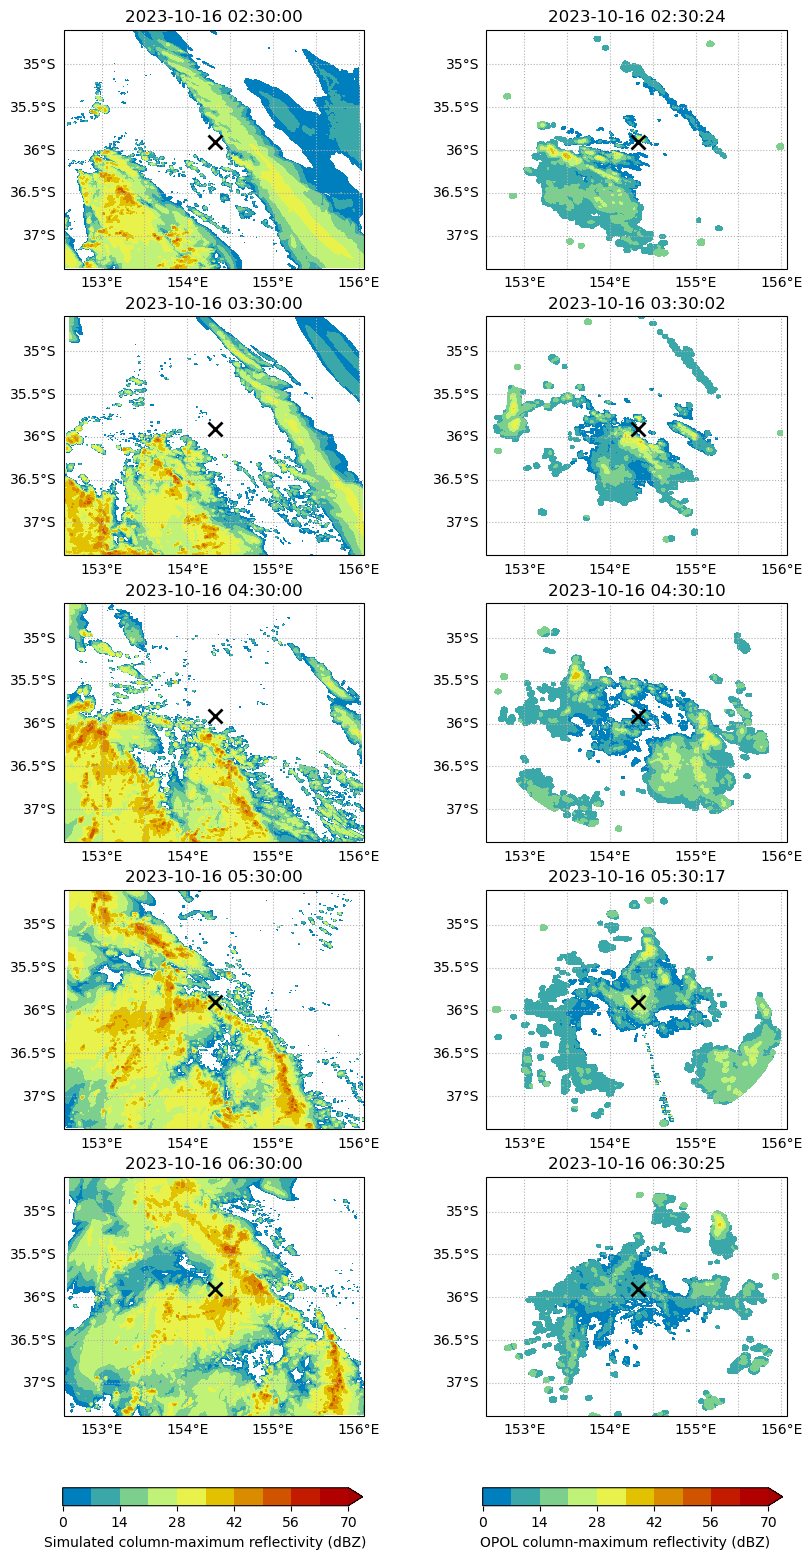

In [6]:
def read_grid(t):
    path1 = "/g/data/w40/ab4502/IN2023_V06/data/radar/opol/grids/opol_"
    path2 = "_grids.nc"    
    grid = pyart.io.read_grid(path1+t+path2).to_xarray()
    obs_lon, obs_lat = np.meshgrid(grid.lon.values,grid.lat.values)
    return grid,obs_lon,obs_lat

def read_swirl(t,step=10,z=1500):
    path = "/g/data/w40/ab4502/IN2023_V06/data/radar/510/20231016/510_20231016_"
    swirl = xr.open_dataset(path+t+".nc")
    mask = swirl.retrieval_mask.sel(z=z)
    u = swirl.vx.sel(z=z)
    v = swirl.vy.sel(z=z)
    u = xr.where(mask==0,np.nan,u)
    v = xr.where(mask==0,np.nan,v)
    u = u.isel(y=range(0,swirl.y.shape[0],step),x=range(0,swirl.x.shape[0],step))
    v = v.isel(y=range(0,swirl.y.shape[0],step),x=range(0,swirl.x.shape[0],step))
    lon = swirl.longitude.isel(y=range(0,swirl.y.shape[0],step),x=range(0,swirl.x.shape[0],step))
    lat = swirl.latitude.isel(y=range(0,swirl.y.shape[0],step),x=range(0,swirl.x.shape[0],step))    
    return lon,lat,u,v

fig = plt.figure(figsize=(10,18)) 

grid_times = ["20231016_023000","20231016_033000","20231016_043000","20231016_053000","20231016_063000"]
swirl_times = ["0230","0330","0430","0530","0630"]    
    
cnt=1
for t in tqdm.tqdm(range(len(wrf_list))):
    ax = plt.subplot(len(wrf_list),2,cnt,projection=ccrs.PlateCarree())
    c=ax.contourf(wrf_lons.values, wrf_lats.values, wrf_refl.isel(Time=t), transform=ccrs.PlateCarree(), cmap=pyart.graph.cm_colorblind.HomeyerRainbow, 
                  levels=np.linspace(0,70,11), extend="max")
    add_lines(ax)
    plt.title(pd.to_datetime(wspd_wdir10.Time.isel(Time=t).values))
    ax.plot(154.3239, -35.9070, marker="x", color="k", ms=10, mew=2)
    if t == 4:
        cax = plt.axes([0.15,0.06,0.3,0.01])
        cb = plt.colorbar(c,cax,orientation="horizontal")
        cb.set_label("Simulated column-maximum reflectivity (dBZ)") 
    wrf_extents = ax.get_extent()
    cnt = cnt+1
    
    ax = plt.subplot(len(wrf_list),2,cnt,projection=ccrs.PlateCarree())
    grid,obs_lon,obs_lat = read_grid(grid_times[t])
    #lon,lat,u,v = read_swirl(swirl_times[t])
    c=ax.contourf(obs_lon, obs_lat, grid.DBZH.isel(time=0).max("z"), transform=ccrs.PlateCarree(), cmap=pyart.graph.cm_colorblind.HomeyerRainbow, 
                  levels=np.linspace(0,70,11), extend="max")
    #ax.quiver(lon,lat,u,v,scale=300,width=0.005)
    ax.plot(154.3239, -35.9070, marker="x", color="k", ms=10, mew=2)
    plt.title(grid.time.values[0].replace(microsecond=0))
    add_lines(ax)
    ax.set_extent(wrf_extents)
    if t == 4:
        cax = plt.axes([0.57,0.06,0.3,0.01])
        cb = plt.colorbar(c,cax,orientation="horizontal")
        cb.set_label("OPOL column-maximum reflectivity (dBZ)")         
    cnt=cnt+1

In [7]:
def get_wrf_wind(wrf_list,bottom_top,t):
    #bottom_top = 11 for ~1000 m AGL, 7 for ~500 m AGL
    u = wrf.getvar(wrf_list,"U",timeidx=t).isel(bottom_top=bottom_top).persist()
    v = wrf.getvar(wrf_list,"V",timeidx=t).isel(bottom_top=bottom_top).persist()
    wspd_wdir = wrf.getvar(wrf_list,"wspd_wdir",timeidx=t).isel(bottom_top=bottom_top).persist()
    return u,v,wspd_wdir



/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/coding/variables.py:214: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/coding/variables.py:214: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/coding/variables.py:214: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/coding/variables.py:214: FutureWarning: elementwise comparison failed; returning scalar instead, but 

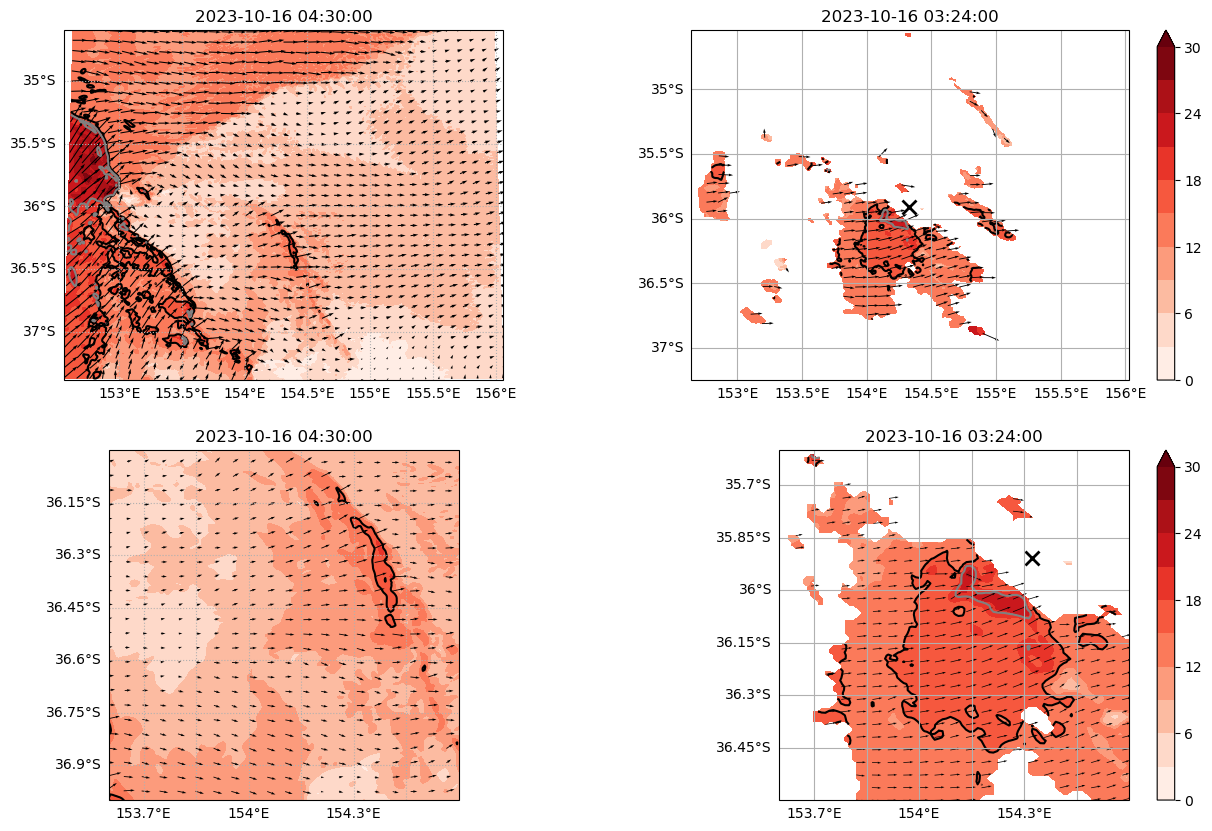

In [28]:
#Get WRF wind and direction at model level z
t=0
z=7

path = "/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa/highres_d04_2023-10-16_"
times = ["04:30:00"]
wrf_list = [nc.Dataset(path+t) for t in times]
wrf_u,wrf_v,wspd_wdir = get_wrf_wind(wrf_list,0,t)

plt.figure(figsize=[16,10])

#Set plotting bounds and WRF quiver step
lats = [-37,-36]
lons = [153.6,154.6]

#Plot WRF for whole d04
ax = plt.subplot(2,2,1,projection=ccrs.PlateCarree())
#Speed
c=ax.contourf(wrf_lons.values, wrf_lats.values, wspd_wdir.isel(wspd_wdir=0), transform=ccrs.PlateCarree(), levels=np.linspace(0,30,11),extend="max",cmap=plt.get_cmap("Reds"))
ax.contour(wrf_lons.values, wrf_lats.values, wspd_wdir.isel(wspd_wdir=0), transform=ccrs.PlateCarree(), levels=[15,20], colors=["k","grey"])
add_lines(ax)
plt.title(pd.to_datetime(wspd_wdir.Time.values))
#Quiver
step=20
xinds = wrf_lons.west_east.shape[0]
yinds = wrf_lons.south_north.shape[0]
ax.quiver(wrf_lons.isel(south_north=range(0,yinds,step),west_east=range(0,xinds,step)), 
          wrf_lats.isel(south_north=range(0,yinds,step),west_east=range(0,xinds,step)), 
          wrf.destagger(wrf_u,1,meta=True).isel(south_north=range(0,yinds,step),west_east=range(0,xinds,step)), 
          wrf.destagger(wrf_v,0,meta=True).isel(south_north=range(0,yinds,step),west_east=range(0,xinds,step)),
         scale=400)

#Plot for just the bounds above
ax = plt.subplot(2,2,3,projection=ccrs.PlateCarree())
#Speed
c=ax.contourf(wrf_lons.values, wrf_lats.values, wspd_wdir.isel(wspd_wdir=0), transform=ccrs.PlateCarree(), levels=np.linspace(0,30,11),extend="max",cmap=plt.get_cmap("Reds"))
ax.contour(wrf_lons.values, wrf_lats.values, wspd_wdir.isel(wspd_wdir=0), transform=ccrs.PlateCarree(), levels=[15,20], colors=["k","grey"])
add_lines(ax)
plt.title(pd.to_datetime(wspd_wdir.Time.values))
#Quiver
step=10
xinds = wrf_lons.west_east.shape[0]
yinds = wrf_lons.south_north.shape[0]
ax.quiver(wrf_lons.isel(south_north=range(0,yinds,step),west_east=range(0,xinds,step)), 
          wrf_lats.isel(south_north=range(0,yinds,step),west_east=range(0,xinds,step)), 
          wrf.destagger(wrf_u,1,meta=True).isel(south_north=range(0,yinds,step),west_east=range(0,xinds,step)), 
          wrf.destagger(wrf_v,0,meta=True).isel(south_north=range(0,yinds,step),west_east=range(0,xinds,step)),
         scale=400)
ax.set_extent([lons[0],lons[1],lats[0],lats[1]])



#Now plot SWIRL

t="0324"
title="2023-10-16 03:24:00"
z=500

lons = [153.6,154.6]
lats = [-36.6,-35.6]

ax=plt.subplot(2,2,2,projection=ccrs.PlateCarree())
lon,lat,u,v = read_swirl(t,z=z,step=1)
lon_q,lat_q,u_q,v_q = read_swirl(t,z=z,step=8)
c=ax.contourf(lon,lat,np.sqrt(u**2+v**2),levels=np.linspace(0,30,11),extend="max",cmap=plt.get_cmap("Reds"))
ax.contour(lon, lat, np.sqrt(u**2+v**2), transform=ccrs.PlateCarree(), levels=[15,20], colors=["k","grey"])
ax.quiver(lon_q,lat_q,u_q,v_q,scale=500,width=0.002)
plt.colorbar(c)
ax.gridlines(draw_labels=["bottom","left"])
ax.set_title(title)
ax.plot(154.3239, -35.9070, marker="x", color="k", ms=10, mew=2)

ax=plt.subplot(2,2,4,projection=ccrs.PlateCarree())
lon,lat,u,v = read_swirl(t,z=z,step=1)
lon_q,lat_q,u_q,v_q = read_swirl(t,z=z,step=4)
c=ax.contourf(lon,lat,np.sqrt(u**2+v**2),levels=np.linspace(0,30,11),extend="max",cmap=plt.get_cmap("Reds"))
ax.contour(lon, lat, np.sqrt(u**2+v**2), transform=ccrs.PlateCarree(), levels=[15,20], colors=["k","grey"])
ax.quiver(lon_q,lat_q,u_q,v_q,scale=500,width=0.002)
plt.colorbar(c)
ax.gridlines(draw_labels=["bottom","left"])
ax.set_extent([lons[0],lons[1],lats[0],lats[1]])
ax.set_title(title)
ax.plot(154.3239, -35.9070, marker="x", color="k", ms=10, mew=2)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/coding/variables.py:214: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/coding/variables.py:214: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/coding/variables.py:214: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/coding/variables.py:214: FutureWarning: elementwise comparison failed; returning scalar instead, but 

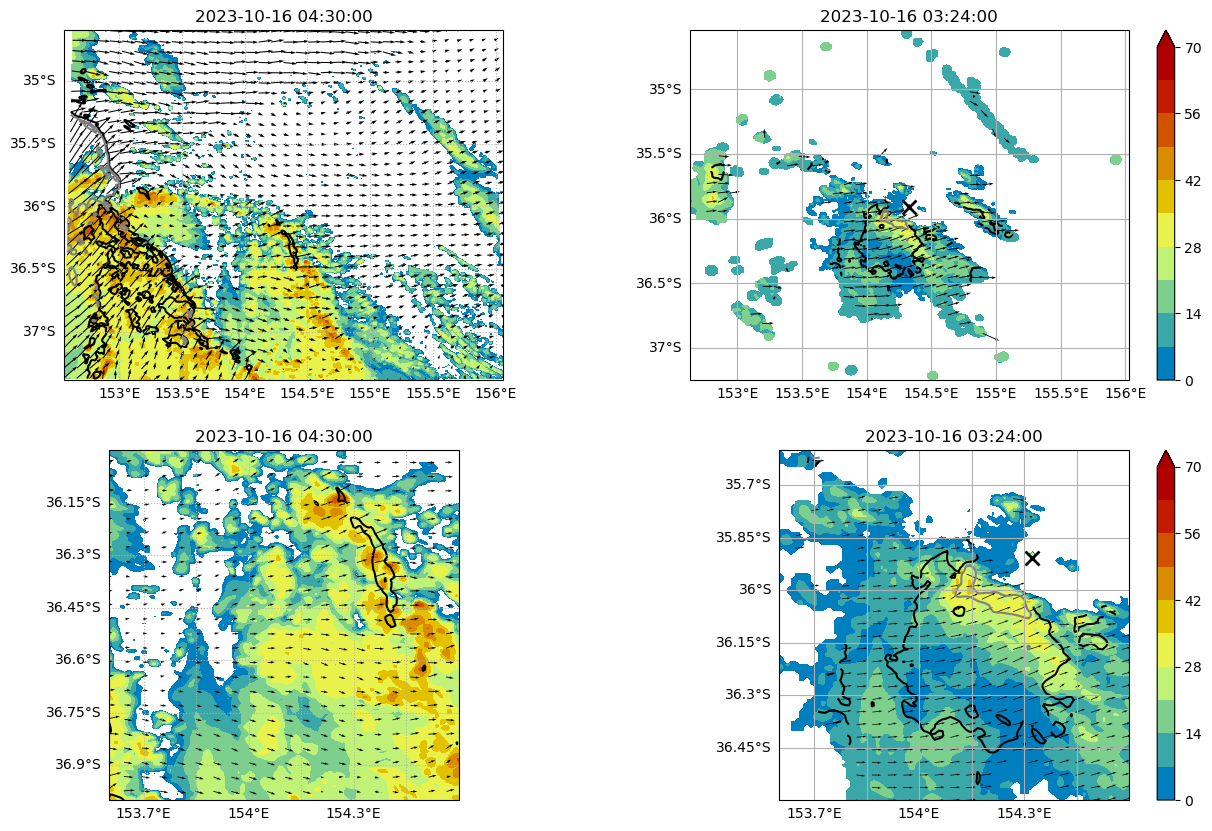

In [13]:
#Get WRF wind and direction at model level z
t=0
z=7

path = "/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa/highres_d04_2023-10-16_"
times = ["04:30:00"]
wrf_list = [nc.Dataset(path+t) for t in times]
wrf_u,wrf_v,wspd_wdir = get_wrf_wind(wrf_list,0,t)

plt.figure(figsize=[16,10])

#Set plotting bounds and WRF quiver step
lats = [-37,-36]
lons = [153.6,154.6]

#Plot WRF for whole d04
ax = plt.subplot(2,2,1,projection=ccrs.PlateCarree())
#Refl
c=ax.contourf(wrf_lons.values, wrf_lats.values, wrf_refl.isel(Time=2), transform=ccrs.PlateCarree(),cmap=pyart.graph.cm_colorblind.HomeyerRainbow, 
                  levels=np.linspace(0,70,11))
ax.contour(wrf_lons.values, wrf_lats.values, wspd_wdir.isel(wspd_wdir=0), transform=ccrs.PlateCarree(), levels=[15,20], colors=["k","grey"])
add_lines(ax)
plt.title(pd.to_datetime(wspd_wdir.Time.values))
#Quiver
step=20
xinds = wrf_lons.west_east.shape[0]
yinds = wrf_lons.south_north.shape[0]
ax.quiver(wrf_lons.isel(south_north=range(0,yinds,step),west_east=range(0,xinds,step)), 
          wrf_lats.isel(south_north=range(0,yinds,step),west_east=range(0,xinds,step)), 
          wrf.destagger(wrf_u,1,meta=True).isel(south_north=range(0,yinds,step),west_east=range(0,xinds,step)), 
          wrf.destagger(wrf_v,0,meta=True).isel(south_north=range(0,yinds,step),west_east=range(0,xinds,step)),
         scale=400)

#Plot for just the bounds above
ax = plt.subplot(2,2,3,projection=ccrs.PlateCarree())
#Refl
c=ax.contourf(wrf_lons.values, wrf_lats.values, wrf_refl.isel(Time=2), transform=ccrs.PlateCarree(),cmap=pyart.graph.cm_colorblind.HomeyerRainbow, 
                  levels=np.linspace(0,70,11))
ax.contour(wrf_lons.values, wrf_lats.values, wspd_wdir.isel(wspd_wdir=0), transform=ccrs.PlateCarree(), levels=[15,20], colors=["k","grey"])
add_lines(ax)
plt.title(pd.to_datetime(wspd_wdir.Time.values))
#Quiver
step=10
xinds = wrf_lons.west_east.shape[0]
yinds = wrf_lons.south_north.shape[0]
ax.quiver(wrf_lons.isel(south_north=range(0,yinds,step),west_east=range(0,xinds,step)), 
          wrf_lats.isel(south_north=range(0,yinds,step),west_east=range(0,xinds,step)), 
          wrf.destagger(wrf_u,1,meta=True).isel(south_north=range(0,yinds,step),west_east=range(0,xinds,step)), 
          wrf.destagger(wrf_v,0,meta=True).isel(south_north=range(0,yinds,step),west_east=range(0,xinds,step)),
         scale=400)
ax.set_extent([lons[0],lons[1],lats[0],lats[1]])



#Now plot SWIRL

t="0324"
grid_t="20231016_032400"
title="2023-10-16 03:24:00"
z=500

lons = [153.6,154.6]
lats = [-36.6,-35.6]

ax=plt.subplot(2,2,2,projection=ccrs.PlateCarree())
lon,lat,u,v = read_swirl(t,z=z,step=1)
lon_q,lat_q,u_q,v_q = read_swirl(t,z=z,step=8)
grid,obs_lon,obs_lat = read_grid(grid_t)
c=ax.contourf(obs_lon, obs_lat, grid.DBZH.isel(time=0).max("z"), transform=ccrs.PlateCarree(), cmap=pyart.graph.cm_colorblind.HomeyerRainbow, 
              levels=np.linspace(0,70,11), extend="max")
ax.contour(lon, lat, np.sqrt(u**2+v**2), transform=ccrs.PlateCarree(), levels=[15,20], colors=["k","grey"])
ax.quiver(lon_q,lat_q,u_q,v_q,scale=500,width=0.002)
plt.colorbar(c)
ax.gridlines(draw_labels=["bottom","left"])
ax.set_title(title)
ax.plot(154.3239, -35.9070, marker="x", color="k", ms=10, mew=2)

ax=plt.subplot(2,2,4,projection=ccrs.PlateCarree())
lon,lat,u,v = read_swirl(t,z=z,step=1)
lon_q,lat_q,u_q,v_q = read_swirl(t,z=z,step=4)
c=ax.contourf(obs_lon, obs_lat, grid.DBZH.isel(time=0).max("z"), transform=ccrs.PlateCarree(), cmap=pyart.graph.cm_colorblind.HomeyerRainbow, 
              levels=np.linspace(0,70,11), extend="max")
ax.contour(lon, lat, np.sqrt(u**2+v**2), transform=ccrs.PlateCarree(), levels=[15,20], colors=["k","grey"])
ax.quiver(lon_q,lat_q,u_q,v_q,scale=500,width=0.002)
plt.colorbar(c)
ax.gridlines(draw_labels=["bottom","left"])
ax.set_extent([lons[0],lons[1],lats[0],lats[1]])
ax.set_title(title)
ax.plot(154.3239, -35.9070, marker="x", color="k", ms=10, mew=2)

In [23]:
wrf_refl3d = wrf.getvar(wrf_list,"dbz",timeidx=0)


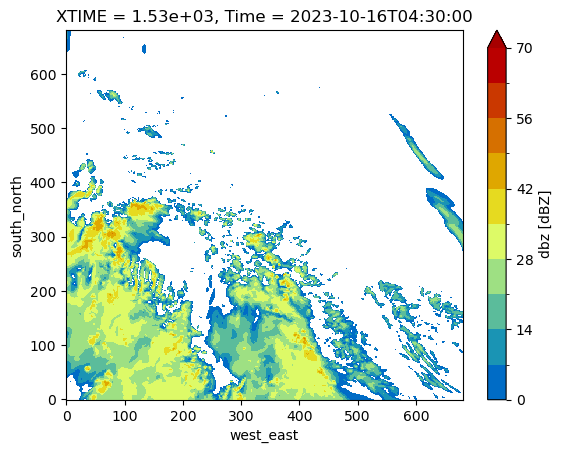

In [24]:
wrf_refl3d.isel(bottom_top=19).plot(cmap=pyart.graph.cm_colorblind.HomeyerRainbow, 
              levels=np.linspace(0,70,11), extend="max")

In [17]:
h = wrf.getvar(wrf_list,"height_agl")

In [20]:
h.isel(bottom_top=19)

<xarray.DataArray 'height_agl' (south_north: 681, west_east: 681)>
array([[2612.7878, 2612.766 , 2612.7732, ..., 2634.8684, 2634.9438,
        2635.0059],
       [2612.7854, 2612.7651, 2612.7634, ..., 2634.9133, 2635.027 ,
        2635.0864],
       [2612.794 , 2612.774 , 2612.7842, ..., 2634.9646, 2635.094 ,
        2635.162 ],
       ...,
       [2651.3682, 2651.3933, 2651.4233, ..., 2677.6997, 2677.7224,
        2677.7334],
       [2651.5356, 2651.556 , 2651.575 , ..., 2677.6777, 2677.7048,
        2677.7334],
       [2651.7148, 2651.7266, 2651.752 , ..., 2677.6448, 2677.676 ,
        2677.7112]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 152.6 152.6 152.6 ... 156.0 156.0
    XLAT     (south_north, west_east) float32 -37.37 -37.37 ... -34.59 -34.59
    XTIME    float32 1.53e+03
    Time     datetime64[ns] 2023-10-16T04:30:00
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XYZ
    description:  model height - [AGL] (mass grid)
    units:        m
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   LambertConformal(stand_lon=154.3000030517578, moad_cen_lat=...

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/coding/variables.py:214: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/coding/variables.py:214: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/coding/variables.py:214: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


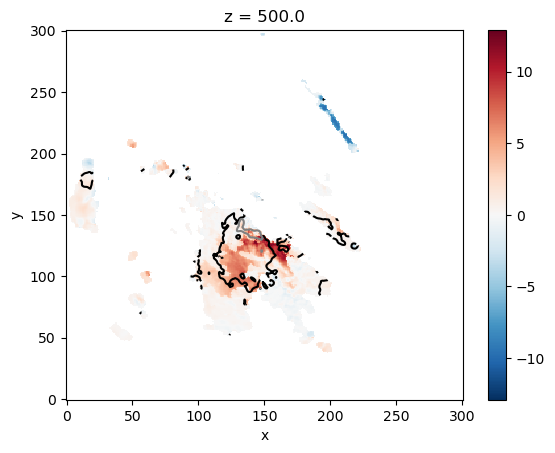

In [26]:
z=500
path = "/g/data/w40/ab4502/IN2023_V06/data/radar/510/20231016/510_20231016_"
t="0324"
swirl = xr.open_dataset(path+t+".nc")
w = swirl.vz.sel(z=z)
u = swirl.vx.sel(z=z)
v = swirl.vy.sel(z=z)
u = xr.where(swirl.sel(z=z).retrieval_mask==0,np.nan,u)
v = xr.where(swirl.sel(z=z).retrieval_mask==0,np.nan,v)
xr.where(swirl.sel(z=z).retrieval_mask==0,np.nan,w).plot()
xr.plot.contour(np.sqrt(u**2+v**2),levels=[15,20],colors=["k","grey"])


In [131]:
swirl

<xarray.Dataset>
Dimensions:           (z: 13, y: 301, x: 301)
Coordinates:
  * z                 (z) float32 0.0 500.0 1e+03 ... 5e+03 5.5e+03 6e+03
Dimensions without coordinates: y, x
Data variables: (12/19)
    latitude          (y, x) float32 ...
    longitude         (y, x) float32 ...
    height            (z) float32 ...
    dx                float32 ...
    dy                float32 ...
    dz                float32 ...
    ...                ...
    vz                (z, y, x) float32 ...
    u_optflow         (z, y, x) float32 ...
    v_optflow         (z, y, x) float32 ...
    dBZ_radar1        (z, y, x) float32 ...
    dop_radar1        (z, y, x) float32 ...
    retrieval_mask    (z, y, x) float32 ...
Attributes: (12/21)
    Conventions:                   CF-1.7;ACDD-1.3
    title:                         Outputs from 3D wind retrieval technique
    references:                    Protat and Zawadzki (1999, JAOT), Collis e...
    institution:                   Commonwealth of Australia, Bureau of Meteo...
    date:                          2023-10-16T03:2
    geospatial_lat_max:            -37.247894
    ...                            ...
    instrument:                    radar
    creator_name:                  Radar Science and Nowcasting Team
    creator_type:                  group
    creator_email:                 alain.protat@bom.gov.au;valentin.louf@bom....
    naming_authority:              au.gov.bom
    license:                       http://www.bom.gov.au/other/copyright.shtml